# ·····························································

# Capacity Test

# ·····························································



In [51]:
import pandas as pd 
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from tabulate import tabulate

In [52]:
def changetonansrepes(name1, date, df):
    
    df1 = df.copy()

    change =  df1[name1]-df1[name1].shift(1)
    print(name1, '\tRegistro igual:', np.any(change == 0))
    
    if np.any(change == 0) == True:
        print('-------------------------------------------------')
        print(name1)
        print('\nEncontramos un registro igual que anterior', change[change == 0].index.tolist())
        print('Sustituimos los registros a nans.')
    
        df.loc[change[change == 0].index.tolist(), [name1]] = np.nan
        print('_________________________________________________')

In [53]:
def changetonans(name1, date, abruptchange, df):
    
    # abrupt change 
    change =  df[name1]-df[name1].shift(1)
    change = abs(change)
    print(name1, '\tAbrupt change > ', abruptchange, ':', np.any(change >= abruptchange))
    
    if np.any(change >= abruptchange) == True:
        print('-------------------------------------------------')
        print(name1)
        print('\nEncontramos un abrupt change en el registro ', change[change > abruptchange].index.tolist())
        print('Sustituimos los registros a nans.')
        
        df.loc[change[change > abruptchange].index.tolist(), [name1]] = np.nan
        
        #descartamos también el registro anterior
        print('Sustituimos el registro anterior a nan.')
        try:
            df.loc[[elemento -1 for elemento in change[change > abruptchange].index.tolist()], [name1]] = np.nan
        except:
            pass
               
        print('_________________________________________________')

In [54]:
# función para calcular la diferencia entre dos columnas y eliminar el registro si es mayor de un determinado valor 
# name1: columna de dataset donde se desea comparar para eliminar
# name2: segunda columna. Preferiblemente la media

def printstd(name1, name2, df, valorper):
    
    df1=df.copy()
    diference = abs(df1[name1] - df1[name2])
    value = df1[name2]*valorper
    
    if np.any(diference >= value) == True:
        print('-------------------------------------------')
        print(name1)
        print('Encontramos diferencias mayores', diference[diference >= value].index.tolist())
        print('Sustituimos por nans.')
        
        df.loc[diference[diference>=value].index.tolist(), [name1]] = np.nan
        
        print('____________________________________________')
    

# ·····························································

## Carga de datos

# ·····························································

In [55]:
path = "./data/"
filelist = os.listdir(path)
filelist

['685_19047 EGE HAINA-GIRASOL_VCS_HourlyRes_0.CSV',
 'GIRASOL_PRUEBAS CAP_2021_0803-0809.xlsb',
 'GIRASOL_PRUEBAS CAP_2021_0803-0810.xlsb',
 'GIRASOL_PRUEBAS CAP_2021_0815-0821 (15-min).xlsb',
 'GIRASOL_PRUEBAS CAP_2021_0815-0821 (15-min).xlsx',
 'GIRASOL_PRUEBAS _10.xlsx',
 'GIRASOL_PRUEBAS.xlsx',
 'GIRASOL_PRUEBAS_15.xlsb',
 'GIRASOL_PRUEBAS_15.xlsx',
 'GIRASOL_PRUEBAS_16.xlsb',
 'GIRASOL_PRUEBAS_16.xlsx',
 'new.xlsx',
 '~$GIRASOL_PRUEBAS_15.xlsx']

# ·····························································

## Serie PVsyst

# ·····························································

In [56]:
vcs = pd.read_csv(path + filelist[0], skiprows = [0,1,2,3,4,5,6,7,8,9,11])#, sep = ',',decimal=".")
vcs['fecha']= pd.to_datetime(vcs['fecha'],  format = '%d/%m/%y %H:%M' )
vcs['month'] = vcs.fecha.dt.month
vcs 

,fecha,GlobInc,T_Amb,WindVel,ShdBLss,IL_Vmin,IL_Pmax,IL_Imax,EOutInv,EGrdLim,E_Grid,month
0,1990-01-01 00:00:00,0.0,25.39,1.9000,0,0,0,0,-5760,0,-259973,1
1,1990-01-01 01:00:00,0.0,25.39,1.1999,0,0,0,0,-5760,0,-259973,1
2,1990-01-01 02:00:00,0.0,24.99,1.1001,0,0,0,0,-5760,0,-259973,1
3,1990-01-01 03:00:00,0.0,24.81,1.4001,0,0,0,0,-5760,0,-259973,1
4,1990-01-01 04:00:00,0.0,24.62,1.4001,0,0,0,0,-5760,0,-259973,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1990-12-31 19:00:00,0.0,25.47,2.4001,0,0,0,0,-5760,0,-259973,12
8756,1990-12-31 20:00:00,0.0,23.92,1.6000,0,0,0,0,-5760,0,-259973,12
8757,1990-12-31 21:00:00,0.0,22.36,0.4000,0,0,0,0,-5760,0,-259973,12
8758,1990-12-31 22:00:00,0.0,20.81,0.1999,0,0,0,0,-5760,0,-259973,12


#### Filtramos los datos para las limitaciones IL_V, IL_P, IL_I, EGrdLim y para E_Grid > 0 (irradiancia)

In [57]:
vcs = vcs[(vcs.EGrdLim == 0) & (vcs.IL_Vmin == 0) & (vcs.IL_Pmax == 0) & (vcs.IL_Imax == 0) & (vcs.E_Grid > 0) & (vcs.ShdBLss == 0)]
print('Después de filtrar tenemos', vcs.shape[0], 'registros')

# Irradiance less than 400W/m^2 will be excluded

vcs = vcs[vcs.GlobInc > 400]
#vcs = vcs[vcs.GlobInc < 999]

vcs.describe()

Después de filtrar tenemos 4161 registros


,GlobInc,T_Amb,WindVel,ShdBLss,IL_Vmin,IL_Pmax,IL_Imax,EOutInv,EGrdLim,E_Grid,month
count,2912.000000,2912.000000,2912.000000,2912.0,2912.0,2912.0,2912.0,2.912000e+03,2912.0,2.912000e+03,2912.000000
mean,760.695810,28.274770,3.466762,0.0,0.0,0.0,0.0,7.584843e+07,0.0,7.418865e+07,6.465659
std,170.098007,2.461868,1.856841,0.0,0.0,0.0,0.0,1.631020e+07,0.0,1.577998e+07,3.397140
min,400.420000,20.160000,0.000000,0.0,0.0,0.0,0.0,3.850721e+07,0.0,3.786909e+07,1.000000
25%,634.182500,26.740000,2.100100,0.0,0.0,0.0,0.0,6.372172e+07,0.0,6.250315e+07,4.000000
50%,790.700000,28.600000,3.200000,0.0,0.0,0.0,0.0,7.898920e+07,0.0,7.727998e+07,6.000000
75%,899.100000,30.070000,4.590100,0.0,0.0,0.0,0.0,8.896919e+07,0.0,8.688252e+07,9.000000
max,1064.300000,33.720000,10.900000,0.0,0.0,0.0,0.0,1.015860e+08,0.0,9.894537e+07,12.000000


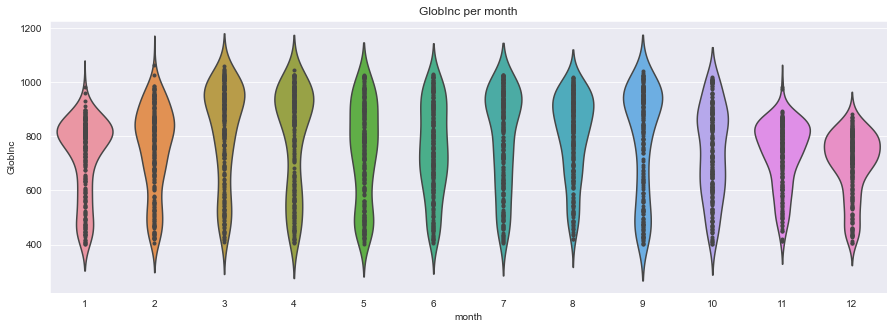

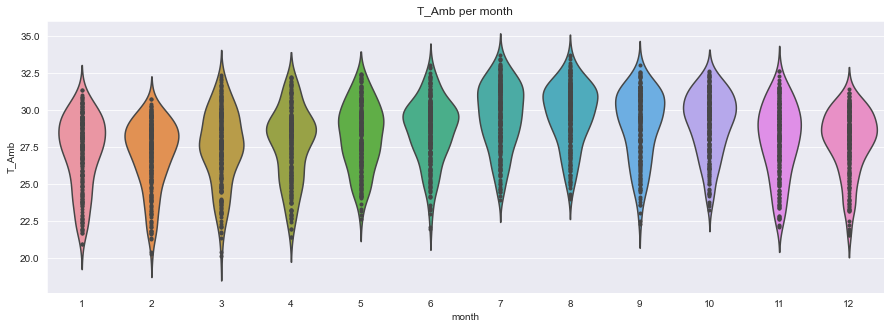

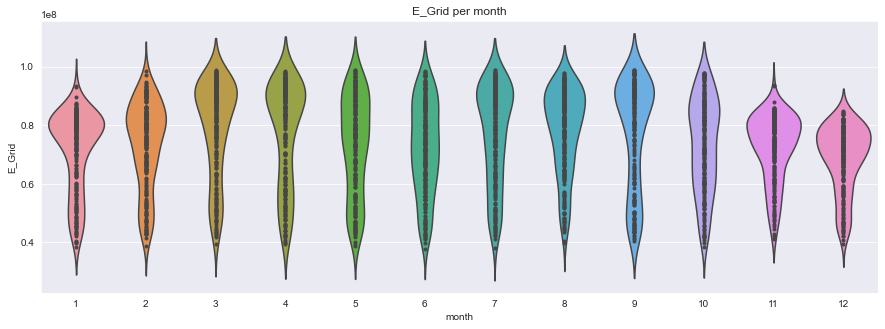

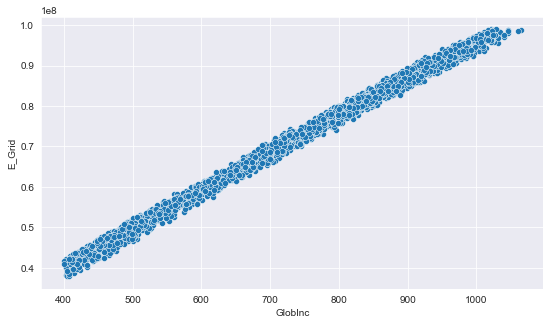

In [58]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (15,5))
sns.violinplot(data = vcs, x = 'month', y = 'GlobInc', inner = 'points', ax = ax)
plt.title('GlobInc per month')
plt.show()

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (15,5))
sns.violinplot(data = vcs, x = 'month', y = 'T_Amb', inner = 'points', ax = ax)
plt.title('T_Amb per month')
plt.show()

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (15,5))
sns.violinplot(data = vcs, x = 'month', y = 'E_Grid', inner = 'points', ax = ax)
plt.title('E_Grid per month')
plt.show()

fig, ax = plt.subplots(figsize= (9,5))
sns.set_style('darkgrid')
sns.scatterplot(data = vcs, x = 'GlobInc', y = 'E_Grid')

### Filter to test period

 Day | Points per day
---------------------
  1  |      88
  2  |      97
  3  |      93
  4  |      87
  5  |      91
  6  |      108
  7  |      112
  8  |      101
  9  |      113
  10  |      93
  11  |      99
  12  |      100
  13  |      91
  14  |      85
  15  |      98
  17  |      96
  18  |      103
  19  |      103
  20  |      90
  21  |      86
  22  |      87
  23  |      90
  24  |      104
  25  |      102
  26  |      104
  27  |      105
  28  |      96
  29  |      81
  30  |      81
  31  |      56
  16  |      72
---------------------
Total | 2912


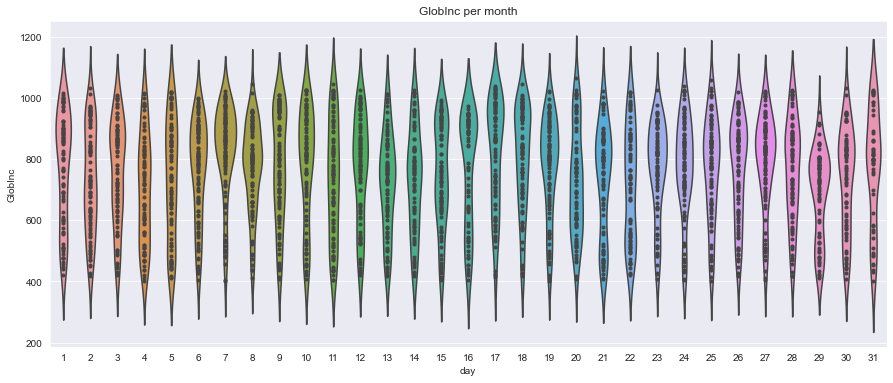

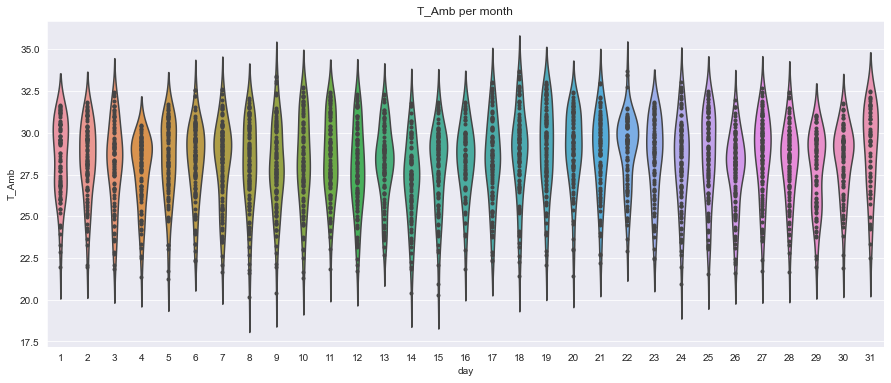

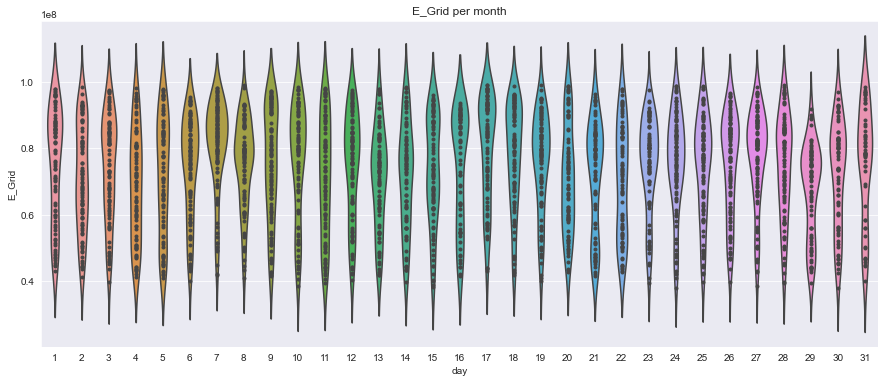

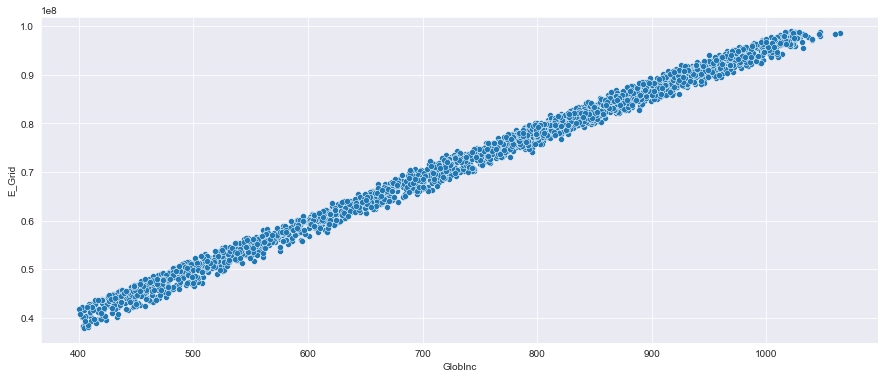

In [59]:
# filter to the test period 

#vcs1 = vcs[(vcs.fecha.dt.month == 8) & (vcs.fecha.dt.day > 2) & (vcs.fecha.dt.day < 11) & (vcs.fecha.dt.day != 9)]
#vcs1 = vcs[(vcs.fecha.dt.month == 8)]
vcs1 = vcs.copy()
vcs1['day'] = vcs1.fecha.dt.day

print(' Day | Points per day')
print('---------------------')
for i in vcs1.fecha.dt.day.unique():
    print(' ', i, ' |     ', vcs1[vcs1.fecha.dt.day == i].shape[0])
print('---------------------')
print('Total |', vcs1.shape[0])

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (15,6))
sns.violinplot(data = vcs1, x = 'day', y = 'GlobInc', inner = 'points', ax = ax)
plt.title('GlobInc per month')
plt.show()

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (15,6))
sns.violinplot(data = vcs1, x = 'day', y = 'T_Amb', inner = 'points', ax = ax)
plt.title('T_Amb per month')
plt.show()

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (15,6))
sns.violinplot(data = vcs1, x = 'day', y = 'E_Grid', inner = 'points', ax = ax)
plt.title('E_Grid per month')
plt.show()

fig, ax = plt.subplots(figsize= (15,6))
sns.set_style('darkgrid')
sns.scatterplot(data = vcs1, x = 'GlobInc', y = 'E_Grid')
plt.show()

## ·····························································

## Datos Campo

## ·····························································

## Pre-filtrado

In [60]:
campdata10 = pd.read_excel('./data/GIRASOL_PRUEBAS _10.xlsx', sheet_name = 'WEATHER', skiprows = [0,1,2])

# add datetime colum
campdata10['Time'] = (pd.to_datetime(campdata10['Time'].str.strip(), format='%I:%M %p')
                  .dt.strftime('%H:%M'))
campdata10['datetime'] = pd.to_datetime(campdata10["Date"].astype(str) + " " + campdata10["Time"].astype(str))

# add potencia columns and others filters

campenergies10 = pd.read_excel('./data/GIRASOL_PRUEBAS _10.xlsx', sheet_name = 'ENERGIES', skiprows = [0,1,2])
campenergies10 = campenergies10[:-4]
campdata10['Paci'] = campenergies10['PACi']

campavil10 = pd.read_excel('./data/GIRASOL_PRUEBAS _10.xlsx', sheet_name = 'AVAILABILITY', skiprows = [0,1,2])
campdata10['AL_exclusion'] = campavil10['AL Exclusion']

campaval10 = pd.read_excel('./data/GIRASOL_PRUEBAS _10.xlsx', sheet_name = 'CALCULUS', skiprows = [0,1,2])
campdata10['Valid'] = campaval10['Valid']

campdata15 = pd.read_excel('./data/GIRASOL_PRUEBAS_15.xlsx', sheet_name = 'WEATHER', skiprows = [0,1,2])

# add datetime colum
campdata15['Time'] = (pd.to_datetime(campdata15['Time'].str.strip(), format='%I:%M %p')
                  .dt.strftime('%H:%M'))
campdata15['datetime'] = pd.to_datetime(campdata15["Date"].astype(str) + " " + campdata15["Time"].astype(str))


# add potencia columns and others filters

campenergies10 = pd.read_excel('./data/GIRASOL_PRUEBAS_15.xlsx', sheet_name = 'ENERGIES', skiprows = [0,1,2])
campenergies10 = campenergies10[:-4]
campdata15['Paci'] = campenergies10['PACi']

campavil10 = pd.read_excel('./data/GIRASOL_PRUEBAS_15.xlsx', sheet_name = 'AVAILABILITY', skiprows = [0,1,2])
campdata15['AL_exclusion'] = campavil10['AL Exclusion']

campaval10 = pd.read_excel('./data/GIRASOL_PRUEBAS_15.xlsx', sheet_name = 'CALCULUS', skiprows = [0,1,2])
campdata15['Valid'] = campaval10['Valid']

campdata10 = pd.concat([campdata10, campdata15])

campdata16 = pd.read_excel('./data/GIRASOL_PRUEBAS CAP_2021_0815-0821 (15-min).xlsx', sheet_name = 'WEATHER', skiprows = [0,1,2])
campdata16 = campdata16[:674] 

# add datetime colum
campdata16['Time'] = (pd.to_datetime(campdata16['Time'].str.strip(), format='%I:%M %p')
                  .dt.strftime('%H:%M'))
campdata16['datetime'] = pd.to_datetime(campdata16["Date"].astype(str) + " " + campdata16["Time"].astype(str))

# add potencia columns and others filters
campenergies10 = pd.read_excel('./data/GIRASOL_PRUEBAS CAP_2021_0815-0821 (15-min).xlsx', sheet_name = 'ENERGIES', skiprows = [0,1,2])
campenergies10 = campenergies10[:674] 
campdata16['Paci'] = campenergies10['PACi']

campavil10 = pd.read_excel('./data/GIRASOL_PRUEBAS CAP_2021_0815-0821 (15-min).xlsx', sheet_name = 'AVAILABILITY', skiprows = [0,1,2])
campavil10 = campavil10[:674]
campdata16['AL_exclusion'] = campavil10['AL Exclusion']

campaval10 = pd.read_excel('./data/GIRASOL_PRUEBAS CAP_2021_0815-0821 (15-min).xlsx', sheet_name = 'CALCULUS', skiprows = [0,1,2])
campaval10 = campaval10[:674]
campdata16['Valid'] = campaval10['Valid']

campdata16 = campdata16[campdata16['datetime'].dt.day != 15]

campdata10 = pd.concat([campdata10, campdata16])

In [61]:
campdata10 = campdata10[(campdata10.datetime.dt.day == 15) | (campdata10.datetime.dt.day == 16) | 
                            (campdata10.datetime.dt.day == 17) | (campdata10.datetime.dt.day == 18)| (campdata10.datetime.dt.day == 19) |
                            (campdata10.datetime.dt.day == 20) | (campdata10.datetime.dt.day == 21)]

### Irradiancia

In [62]:
df1 = campdata10.melt(id_vars=['datetime'], 
                        value_vars =  campdata10.loc[: , "Meteo 01 - PYR POA":"Meteo 14 - PYR POA"].columns,
                        var_name='AAPL')

fig = px.line(df1, x='datetime', y='value', color='AAPL', title = 'POA', width=1000, height=500)
fig.update_layout(xaxis = go.layout.XAxis( tickangle = 45))
fig.update_layout(showlegend=False)
fig.show()

In [63]:
#for i in campdata10.loc[: , "Meteo 01 - PYR POA":"Meteo 14 - PYR POA"].columns:
#    changetonans(i, 'datetime', 200, campdata10) # eliminar saltos de 100 
#    changetonansrepes(i, 'datetime', campdata10) # eliminar valores estancados

#for i in campdata10.loc[: , "Meteo 01 - PYR POA":"Meteo 14 - PYR POA"].columns:
#    campdata10 = campdata10[campdata10[i].notna()]

In [64]:
# calculamos diferencia entre 

for i in campdata10.loc[:, 'Meteo 01 - PYR POA':'Meteo 14 - PYR POA'].columns:
    printstd(i, 'Meteos - Avg PYR POA', campdata10, 0.15)
    
for i in campdata10.loc[: , "Meteo 01 - PYR POA":"Meteo 14 - PYR POA"].columns:
    campdata10 = campdata10[campdata10[i].notna()]

-------------------------------------------
Meteo 01 - PYR POA
Encontramos diferencias mayores [60, 65, 133, 140, 150, 154, 225, 226, 227, 228, 234, 235, 238, 239, 240, 248, 249, 333, 335, 336, 338, 339, 342, 343, 344, 345, 355, 356, 357, 358, 423, 424, 436, 437, 441, 444, 460, 512, 514, 521, 526, 527, 537, 538, 540, 542, 612, 616, 617, 618, 619, 638, 643, 645, 647, 650]
Sustituimos por nans.
____________________________________________
-------------------------------------------
Meteo 02 - PYR POA
Encontramos diferencias mayores [60, 64, 65, 133, 225, 227, 228, 233, 234, 238, 239, 240, 248, 249, 335, 338, 339, 342, 343, 345, 354, 355, 356, 357, 358, 423, 424, 425, 436, 437, 441, 512, 521, 527, 530, 536, 537, 538, 540, 542, 612, 618, 620, 638, 643, 645, 647, 648, 650]
Sustituimos por nans.
____________________________________________
-------------------------------------------
Meteo 03 - PYR POA
Encontramos diferencias mayores [60, 65, 135, 222, 227, 230, 237, 240, 335, 337, 339, 340, 

### Temperatura

In [65]:
df1 = campdata10.melt(id_vars=['datetime'], 
                        value_vars =  campdata10.loc[: , 'Meteo 01 - Tamb':'Meteo 14 - Tamb'].columns,
                        var_name='AAPL')

fig = px.line(df1, x='datetime', y='value', color='AAPL', title = 'POA', width=1000, height=500)
fig.update_layout(xaxis = go.layout.XAxis( tickangle = 45))
fig.update_layout(showlegend=True)
fig.show()

In [66]:
#for i in campdata10.loc[: , 'Meteo 01 - Tamb':'Meteo 14 - Tamb'].columns:
#    changetonans(i, 'datetime', 3, campdata10) # eliminar saltos de 3ª 
#    changetonansrepes(i, 'datetime', campdata10) # eliminar valores estancados 
#    
#for i in campdata10.loc[: , 'Meteo 01 - Tamb':'Meteo 14 - Tamb'].columns:
#    campdata10 = campdata10[campdata10[i].notna()]

## Carga de datos

In [67]:
#campdata = pd.read_excel('./data/GIRASOL_PRUEBAS.xlsx', sheet_name = 'WEATHER', skiprows = [0,1,2])
#
## add datetime colum
#campdata['Time'] = pd.to_datetime(campdata['Time'],  format = '%H:%M %p' )
#campdata['Time'] = [time.time() for time in campdata['Time']]
#campdata['datetime'] = pd.to_datetime(campdata["Date"].astype(str) + " " + campdata["Time"].astype(str))
#
## add potencia columns and others filters
#
#campenergies = pd.read_excel('./data/GIRASOL_PRUEBAS.xlsx', sheet_name = 'ENERGIES', skiprows = [0,1,2])
#campenergies = campenergies[:-4]
#campdata['Paci'] = campenergies['PACi']
#
#campavil = pd.read_excel('./data/GIRASOL_PRUEBAS.xlsx', sheet_name = 'AVAILABILITY', skiprows = [0,1,2])
#campdata['AL_exclusion'] = campavil['AL Exclusion']
#
#campdata

# añadimos el día 10

#campdata10 = pd.read_excel('./data/GIRASOL_PRUEBAS _10.xlsx', sheet_name = 'WEATHER', skiprows = [0,1,2])
#
## add datetime colum
#campdata10['Time'] = pd.to_datetime(campdata10['Time'],  format = '%H:%M %p' )
#campdata10['Time'] = [time.time() for time in campdata10['Time']]
#campdata10['datetime'] = pd.to_datetime(campdata10["Date"].astype(str) + " " + campdata10["Time"].astype(str))
#
## add potencia columns and others filters
#
#campenergies10 = pd.read_excel('./data/GIRASOL_PRUEBAS _10.xlsx', sheet_name = 'ENERGIES', skiprows = [0,1,2])
#campenergies10 = campenergies10[:-4]
#campdata10['Paci'] = campenergies10['PACi']
#
#campavil10 = pd.read_excel('./data/GIRASOL_PRUEBAS _10.xlsx', sheet_name = 'AVAILABILITY', skiprows = [0,1,2])
#campdata10['AL_exclusion'] = campavil10['AL Exclusion']
#
##campdatafinal = pd.concat([campdata, campdata10])

# generate new dataset with mean of the diferents columns 

campdata_new = pd.DataFrame()

campdata_new['DateTime'] = campdata10['datetime']

campdata_new['day'] = campdata_new.DateTime.dt.day

col = campdata10.loc[: , "Meteo 01 - PYR POA":"Meteo 14 - PYR POA"]
campdata_new['POA'] = col.mean(axis=1)

col = campdata10.loc[:,'Meteo 01 - WS':'Meteo 14 - WS']
campdata_new['WS'] = col.mean(axis=1)

col = campdata10.loc[:, 'Meteo 01 - Tamb':'Meteo 14 - Tamb']
campdata_new['T_Amb'] = col.mean(axis=1)

campdata_new['Paci'] = campdata10['Paci']
campdata_new['AL_exclusion'] = campdata10['AL_exclusion']
campdata_new['Valid'] = campdata10['Valid']

In [68]:
#writer = pd.ExcelWriter('capacity_test.xlsx')
# write dataframe to excel sheet named 'marks'
#campdata_new.to_excel(writer, 'data', index=False)
# save the excel file
#writer.save()

In [69]:
#campdata_new = campdata_new[(campdata_new.day == 15) | (campdata_new.day == 16) | 
#                            (campdata_new.day == 17) | (campdata_new.day == 18)| (campdata_new.day == 19) |
#                           (campdata_new.day == 20) | (campdata_new.day == 21)]

#### Filtrado de datos para saltos de irradiancia y temperatura 

In [70]:
print('Registros pre-filtro', campdata_new.shape[0])
changetonans('POA', 'datetime', 200, campdata_new) # eliminar saltos de 100 
changetonansrepes('POA', 'datetime', campdata_new) # eliminar valores estancados
changetonans('T_Amb', 'datetime', 3, campdata_new) # eliminar saltos de 3ª 
changetonansrepes('T_Amb', 'datetime', campdata_new) # eliminar valores estancados 

# eliminar registros 

for i in ['POA', 'T_Amb']:
    campdata_new = campdata_new[campdata_new[i].notna()]
    
print('Registros post-filtro:', campdata_new.shape[0])

Registros pre-filtro 247
POA 	Abrupt change >  200 : True
-------------------------------------------------
POA

Encontramos un abrupt change en el registro  [61, 141, 151, 224, 229, 236, 244, 245, 246, 359, 418, 431, 438, 440, 443, 445, 513, 519, 522, 523, 524, 528, 532, 541, 549, 551, 621, 641, 646, 651]
Sustituimos los registros a nans.
Sustituimos el registro anterior a nan.
_________________________________________________
POA 	Registro igual: False
T_Amb 	Abrupt change >  3 : True
-------------------------------------------------
T_Amb

Encontramos un abrupt change en el registro  [61, 128, 359]
Sustituimos los registros a nans.
Sustituimos el registro anterior a nan.
_________________________________________________
T_Amb 	Registro igual: False
Registros post-filtro: 216


#### Filtramos los datos para las limitaciones IL_V, IL_P, IL_I, EGrdLim y para E_Grid > 0 (irradiancia)

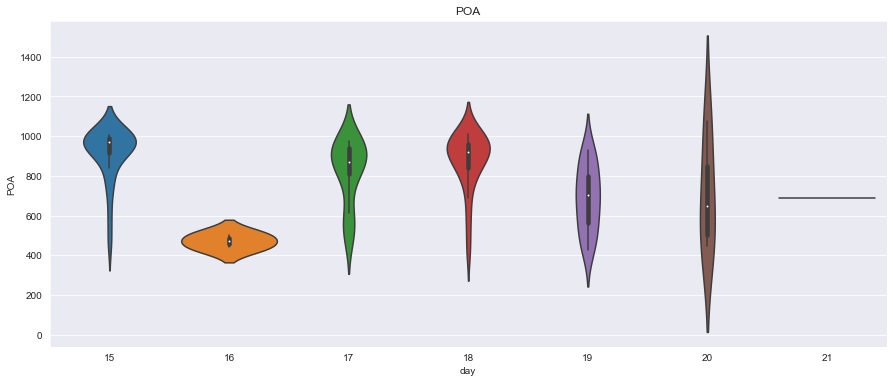

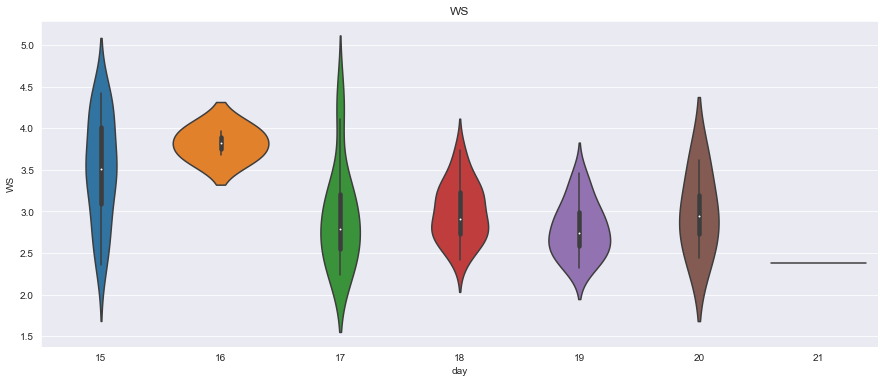

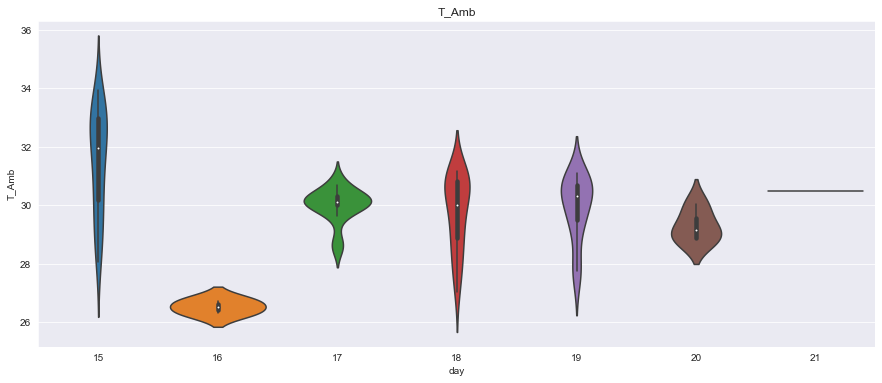

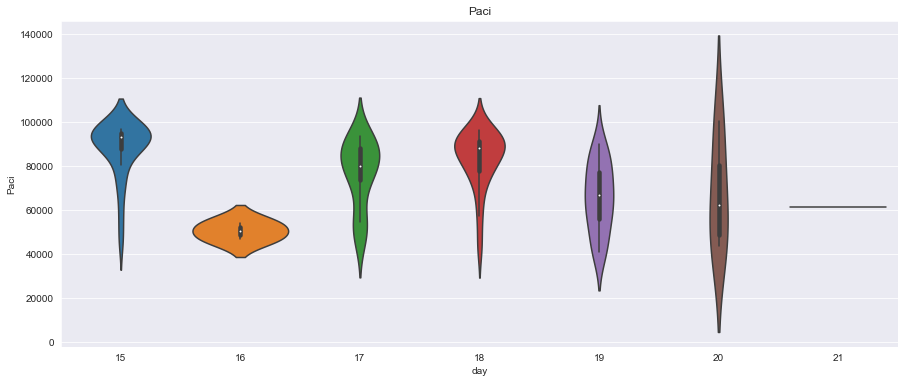

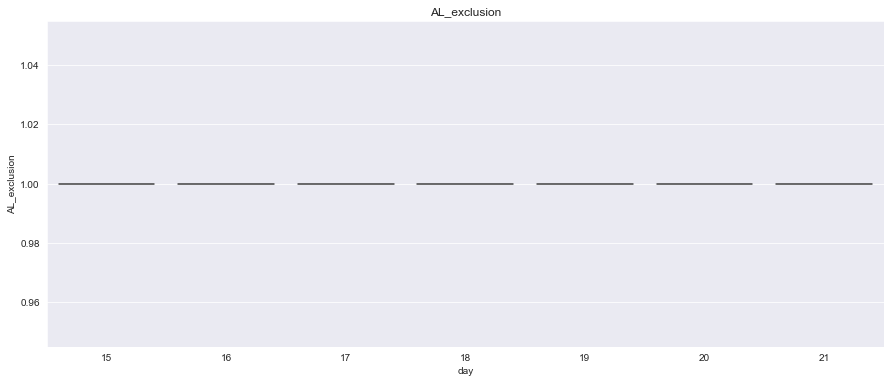

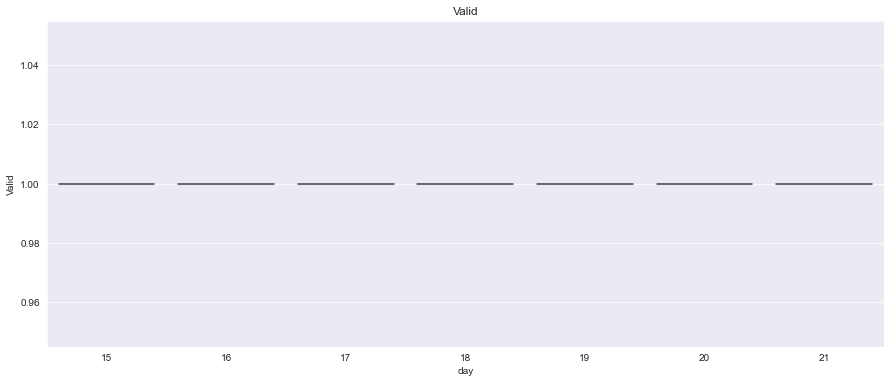

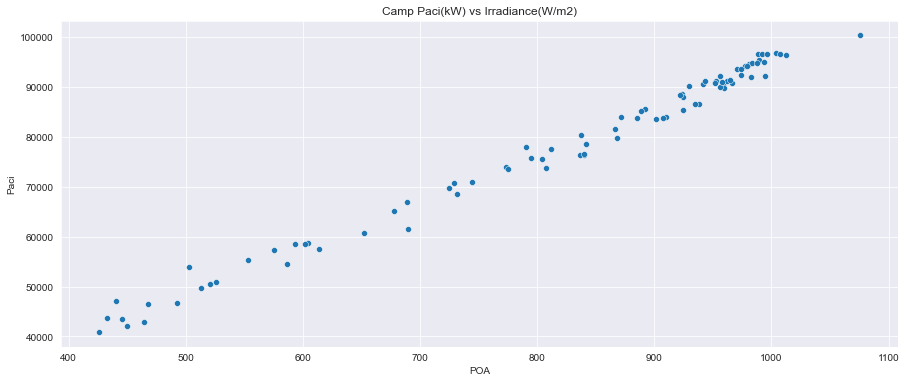

In [71]:
campdata_new = campdata_new[(campdata_new.Valid == 1) & (campdata_new.AL_exclusion == 1)]

# Irradiance less than 400W/m^2 will be excluded

campdata_new = campdata_new[campdata_new.POA > 400]
#campdata_new = campdata_new[campdata_new.POA < 999]

campdata_new.describe()

for i in campdata_new.columns[2:]:
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize = (15,6))
    sns.violinplot(data = campdata_new, x = 'day', y = i,  ax = ax)
    plt.title(i)
    plt.show()
    
fig, ax = plt.subplots(figsize= (15,6))
sns.set_style('darkgrid')
sns.scatterplot(data = campdata_new, x = 'POA', y = 'Paci')
plt.title('Camp Paci(kW) vs Irradiance(W/m2)')
plt.show()

In [72]:
# eliminamos el día nueve 
#campdata_new = campdata_new[campdata_new.day !=9]

# nos quedamos con el día 10 y 15
campdata_new = campdata_new[(campdata_new.day == 15) | (campdata_new.day == 16) | 
                            (campdata_new.day == 17) | (campdata_new.day == 18)| (campdata_new.day == 19) |
                           (campdata_new.day == 20) | (campdata_new.day == 21)]

print(campdata_new.day.unique())

[15 16 17 18 19 20 21]


In [73]:
#campdata_new.to_excel(writer, 'data_filter', index=False)
# save the excel file
#writer.save()

 Day | Points per day
---------------------
  15  |      24
  16  |      2
  17  |      17
  18  |      21
  19  |      18
  20  |      4
  21  |      1
---------------------
Total | 87


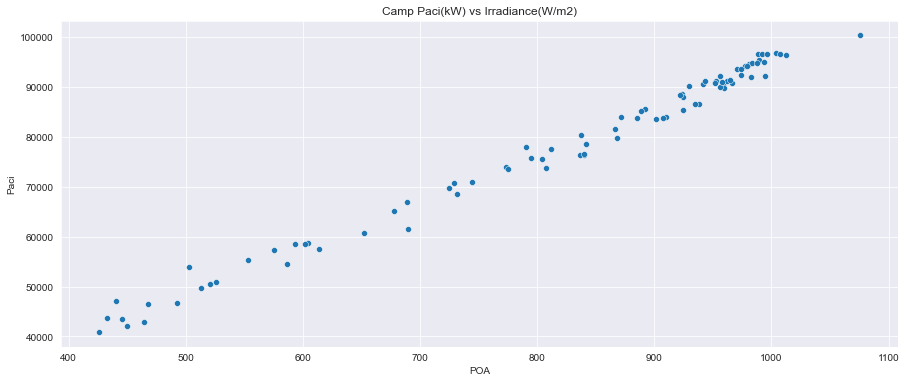

In [74]:
#print(campdata_new[(campdata_new.day == 8) & (campdata_new.AL_exclusion == 0)])

# delete the row with AL_exclusion = 0
#campdata_new = campdata_new.drop(labels=campdata_new[(campdata_new.day == 8) & (campdata_new.AL_exclusion == 0)].index[0], axis=0)

# delete the outliers

#campdata_new = campdata_new.drop(labels=campdata_new[(campdata_new.POA > 700)& (campdata_new.POA < 800) & (campdata_new.Paci < 30000)].index[0], axis=0)
#campdata_new = campdata_new.drop(labels=campdata_new[(campdata_new.POA > 560) &(campdata_new.POA < 600) & (campdata_new.Paci < 50000)].index[0], axis=0)
#campdata_new = campdata_new.drop(labels=campdata_new[(campdata_new.POA > 790) &(campdata_new.POA < 810) & (campdata_new.Paci < 66000)].index[0], axis=0)
#campdata_new = campdata_new.drop(labels=campdata_new[(campdata_new.POA > 580) &(campdata_new.POA < 600) & (campdata_new.Paci < 50000)].index[0], axis=0)

    
print(' Day | Points per day')
print('---------------------')
for i in campdata_new.day.unique():
    print(' ', i, ' |     ', campdata_new[campdata_new.day == i].shape[0])
print('---------------------')
print('Total |', campdata_new.shape[0])


fig, ax = plt.subplots(figsize= (15,6))
sns.set_style('darkgrid')
sns.scatterplot(data = campdata_new, x = 'POA', y = 'Paci')
plt.title('Camp Paci(kW) vs Irradiance(W/m2)')
plt.show()

In [75]:
print(' Day | Points per day')
print('---------------------')
for i in irrcamp.day.unique():
    print(' ', i, ' |     ', irrcamp[irrcamp.day == i].shape[0])
print('---------------------')
print('Total |', irrcamp.shape[0])


 Day | Points per day
---------------------
  20  |      2
  18  |      18
  15  |      22
  17  |      13
  19  |      6
---------------------
Total | 61


# ·····························································

# Determinamos RC (reporting conditions)

# ·····························································

# ·····························································

## Para datos de campo

# ·····························································

### $E_{RC}$

The mean Irradiance is 815.75894909688
The dataset nearest value 929.6628571428571

                DateTime  day         POA        WS      T_Amb     Paci  \
433 2021-08-19 12:00:00   19  929.662857  3.301429  30.549286  90144.0   

     AL_exclusion  Valid  
433             1      1  




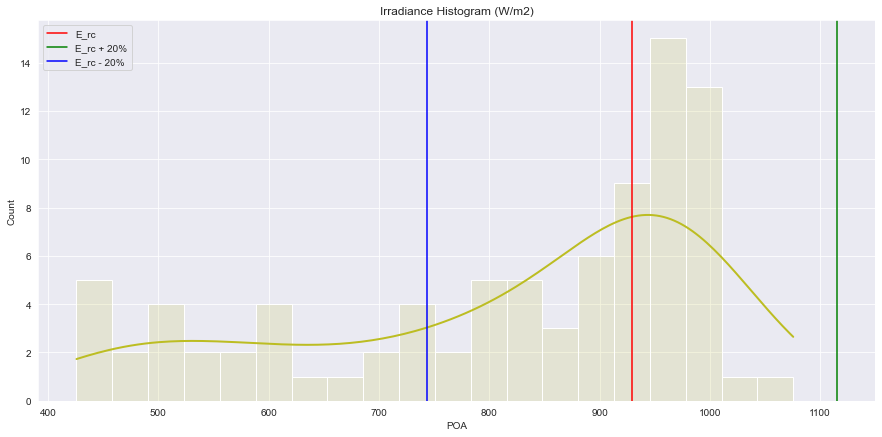

The data points in the range E_rc + 20%:  34
The data points in the range E_rc - 20%:  26

Data points: 61
% of data above Erc: 55.74 %
% of data bellow Erc: 42.62 %


In [76]:
# sort by irradiance 
irrcamp = campdata_new.sort_values('POA', ascending = False).copy()

## mean value
E_mean = irrcamp.POA.mean()
print('The mean Irradiance is', E_mean)
#
## choose the nearest value 
#
absolute_difference_function = lambda list_value : abs(list_value - (E_mean+115))
E_rc = min(irrcamp.POA.tolist(), key=absolute_difference_function)
print('The dataset nearest value', E_rc)
print('\n', irrcamp[irrcamp.POA == E_rc])
print('\n')

# plot the histogram 
fig, ax = plt.subplots(figsize= (15,7))
sns.histplot(data = irrcamp, x = 'POA', stat = 'count', kde = True, alpha = 0.15,
             color   = (list(plt.rcParams['axes.prop_cycle'])*2)[8]["color"], 
             bins = 20,
            line_kws= {'linewidth': 2})
plt.title('Irradiance Histogram (W/m2)')
plt.axvline(E_rc, 0, label="E_rc", color = 'red')
plt.axvline( E_rc + 0.20*E_rc, 0, label="E_rc + 20%", color = 'green')
plt.axvline(E_rc - 0.20*E_rc, 0, label="E_rc - 20%", color = 'blue')
plt.legend()
plt.show()

print('The data points in the range E_rc + 20%: ', irrcamp[(irrcamp.POA < E_rc + 0.20*E_rc) & (irrcamp.POA > E_rc)].shape[0])
print('The data points in the range E_rc - 20%: ', irrcamp[(irrcamp.POA > E_rc - 0.20*E_rc) & (irrcamp.POA < E_rc)].shape[0])
#print('% of data above Erc:', round(irrcamp[irrcamp.POA > E_rc].shape[0]/irrcamp.shape[0]*100,2), '%')
#print('% of data bellow Erc:', round(irrcamp[irrcamp.POA < E_rc].shape[0]/irrcamp.shape[0]*100,2), '%')

irrcamp = irrcamp[irrcamp.POA > E_rc - 0.20*E_rc]
irrcamp = irrcamp[irrcamp.POA < E_rc + 0.20*E_rc]
print('\nData points:', irrcamp.shape[0])
print('% of data above Erc:', round(irrcamp[irrcamp.POA > E_rc].shape[0]/irrcamp.shape[0]*100,2), '%')
print('% of data bellow Erc:', round(irrcamp[irrcamp.POA < E_rc].shape[0]/irrcamp.shape[0]*100,2), '%')

In [77]:
#irrcamp.to_excel(writer, 'data_filter_E_RC', index=False)
# save the excel file
#writer.save()

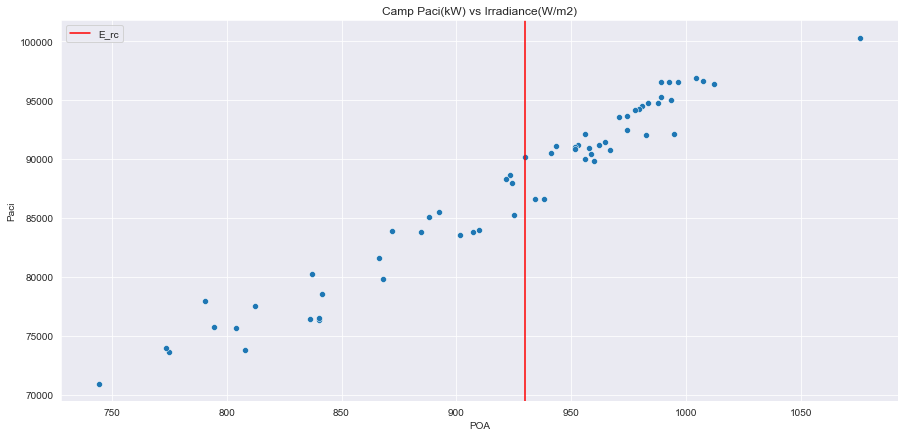

In [78]:
fig, ax = plt.subplots(figsize= (15,7))
sns.set_style('darkgrid')
sns.scatterplot(data = irrcamp, x = 'POA', y = 'Paci')
plt.title('Camp Paci(kW) vs Irradiance(W/m2)')
plt.axvline(E_rc, 0, color = 'red', label = 'E_rc')
plt.legend()
plt.show()

All data where the irradiance is outside of the range [ERC ± 20%] will be excluded

### $T_{RC}$

In [79]:
T_rc = irrcamp.T_Amb.mean()
print('The Temperature reporting conditions is', T_rc, 'ºC')

The Temperature reporting conditions is 30.787283372365348 ºC


### $V_{RC}$ 

RC rating wind speed 1m/s

In [80]:
V_rc = irrcamp.WS.mean()
print('The Wind spped reporting condition is', V_rc, 'm/s')

The Wind spped reporting condition is 3.2634660421545676 m/s


## Para VCS

## ·····························································

The data points in the range E_rc + 20%:  538
The data points in the range E_rc - 20%:  1181

Data points: 1719
% of data above Erc: 31.3 %
% of data bellow Erc: 68.7 %


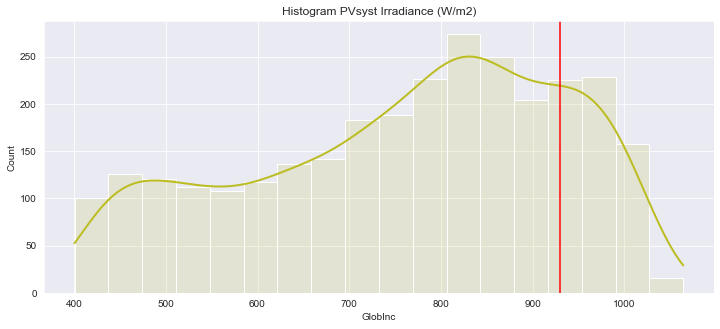

In [81]:
# sort by irradiance 
irr = vcs1.sort_values('GlobInc', ascending = False).copy()

# plot the histogram 
fig, ax = plt.subplots(figsize= (12,5))
sns.histplot(data = irr, x = 'GlobInc', stat = 'count', kde = True, alpha = 0.15,
             color   = (list(plt.rcParams['axes.prop_cycle'])*2)[8]["color"],
            line_kws= {'linewidth': 2})
plt.title('Histogram PVsyst Irradiance (W/m2)')
plt.axvline(E_rc, 0, color = 'red')

print('The data points in the range E_rc + 20%: ', irr[(irr.GlobInc < E_rc + 0.20*E_rc) & (irr.GlobInc > E_rc)].shape[0])
print('The data points in the range E_rc - 20%: ', irr[(irr.GlobInc > E_rc - 0.20*E_rc) & (irr.GlobInc < E_rc)].shape[0])
#print('% of data above Erc:', round(irr[irr.GlobInc > E_rc].shape[0]/irr.shape[0]*100,2), '%')
#print('% of data bellow Erc:', round(irr[irr.GlobInc < E_rc].shape[0]/irr.shape[0]*100,2), '%')

# All data where the irradiance is outside of the range [ERC ± 20%] will be excluded

irr = irr[irr.GlobInc > E_rc - 0.20*E_rc]
irr = irr[irr.GlobInc < E_rc + 0.20*E_rc]
print('\nData points:', irr.shape[0])
print('% of data above Erc:', round(irr[irr.GlobInc > E_rc].shape[0]/irr.shape[0]*100,2), '%')
print('% of data bellow Erc:', round(irr[irr.GlobInc < E_rc].shape[0]/irr.shape[0]*100,2), '%')

In [82]:
#irr.to_excel(writer, 'data_pvsyst', index=False)
# save the excel file
#writer.save()

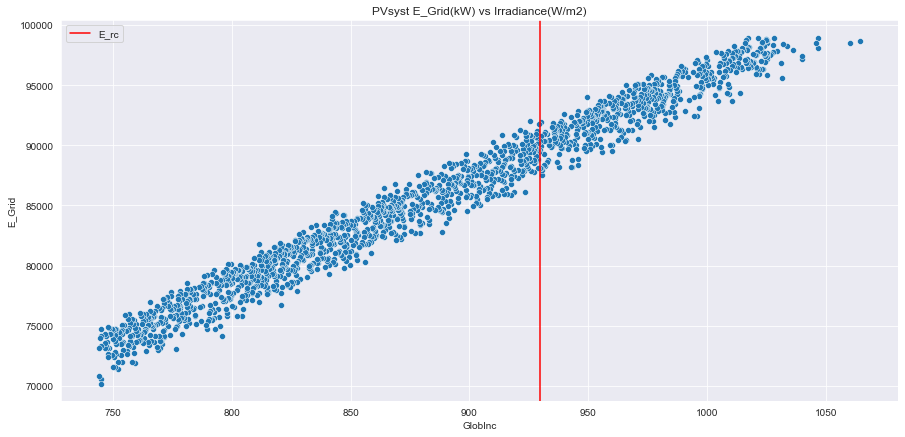

In [83]:
fig, ax = plt.subplots(figsize= (15,7))
sns.set_style('darkgrid')
sns.scatterplot(data = irr, x = 'GlobInc', y = irr['E_Grid']/1000)
plt.title('PVsyst E_Grid(kW) vs Irradiance(W/m2)')
plt.axvline(E_rc, 0, color = 'red', label = 'E_rc')
plt.legend()
plt.show()

In [84]:
print('The Wind Speed mean of PVsyst is', irr.WindVel.mean(), 'm/s')
print('The Temperature Ambient mean of PVsyst is', irr.T_Amb.mean(), 'ºC')

The Wind Speed mean of PVsyst is 3.5817002326934126 m/s
The Temperature Ambient mean of PVsyst is 28.7098254799302 ºC


# ·····························································

# Actual capacity rating

# ·····························································
Calculated power output of the facility at the reporting conditions, based on regression of the actual test Data collected during the test period. 

Determine regression coefficients $a_1$, $a_2$, $a_3$ and $a_4$



$ P = E*a_1 + E^2*a_2 + E*T_a*a_3 + E*V*a_3 $

and determinate $P_{actual} (RC)$

In [85]:
# generate the news columns to make the regression 

newvcs = irrcamp.copy()

newvcs['EE'] = newvcs['POA']*newvcs['POA']
newvcs['ET'] = newvcs['POA']*newvcs['T_Amb']
newvcs['EV'] = newvcs['POA']*newvcs['WS']
newvcs['P'] = (newvcs['Paci']*1000*(1/10**6)) #MW

                                 OLS Regression Results                                
Dep. Variable:                      P   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.095e+04
Date:                Tue, 14 Sep 2021   Prob (F-statistic):                   1.58e-100
Time:                        12:47:56   Log-Likelihood:                         -110.01
No. Observations:                  61   AIC:                                      228.0
Df Residuals:                      57   BIC:                                      236.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

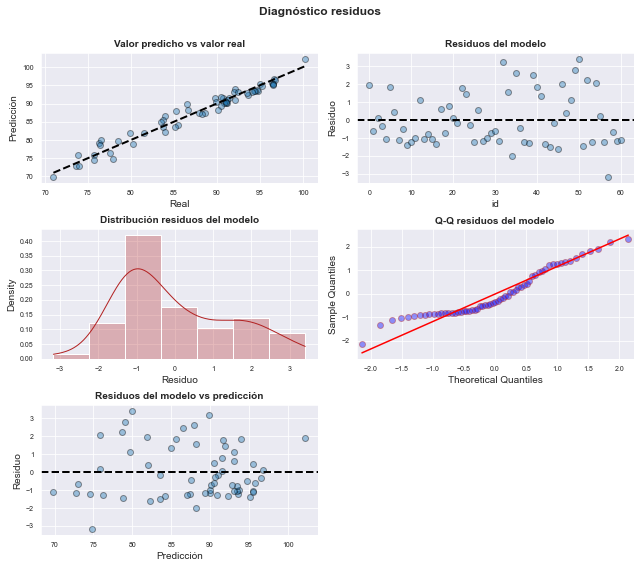

In [86]:
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
#X_train = sm.add_constant(X_train, prepend=True)
import statsmodels.api as sm

X = newvcs[['POA', 'EE', 'ET', 'EV']]
#X = newvcs[['POA', 'EE', 'ET']]
y = newvcs['P']

modelo = sm.OLS(endog=y, exog=X,)
modelo = modelo.fit()
print(modelo.summary())


print('\n==============================================================================')
print('Intervalos de confianza para los coeficientes del modelo')
intervalos_ci = modelo.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
print(intervalos_ci)


print('\n==============================================================================')
print('Diagnóstico errores (residuos) de las predicciones de entrenamiento')

prediccion_train = modelo.predict(exog = X)
residuos_train   = prediccion_train - y

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

y_train = y
axes[0, 0].scatter(y, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [87]:
modelo.rsquared

0.999720370680894

Los residuos parecen distribuirse de forma aleatoria en torno a cero, manteniendo aproximadamente la misma variabilidad a lo largo del eje X. Este patrón apunta a una no falta de homocedasticidad y de distribución normal

In [88]:
print('Los coeficientes del ajuste multiple:\n', modelo.params)

Pactual = E_rc*modelo.params[0] + E_rc*E_rc*modelo.params[1] + E_rc*T_rc*modelo.params[2] + E_rc*V_rc*modelo.params[3]
#Pactual = E_rc*modelo.params[0] + E_rc*E_rc*modelo.params[1] + E_rc*T_rc*modelo.params[2] 
print('\nThe actual capacity rating:', Pactual, 'MW')


Los coeficientes del ajuste multiple:
 POA    8.470508e-02
EE     7.247745e-07
ET     2.320151e-04
EV     7.163073e-04
dtype: float64

The actual capacity rating: 88.18748188157363 MW


# ·····························································

# Contract Capacity Rating

# ·····························································

Power output of the facility at RC, based on regression of the testing model data corresponding to the target priod, same period as test period --> 03/08 to 10/08

$ E_{Grid} = E_{RC}*(a_1+a_2*GlobInc+a_3*T_{Amb}+a_4*WindVel )$

In [89]:
# generate the news columns to make the regression 

newvcs1 = irr.copy()

newvcs1['E_rc'] = newvcs1['GlobInc']
newvcs1['EE'] = newvcs1['GlobInc']*newvcs1['GlobInc']
newvcs1['ET'] = newvcs1['T_Amb']*newvcs1['GlobInc']
newvcs1['EV'] = newvcs1['WindVel']*newvcs1['GlobInc']
newvcs1['P'] = newvcs1.E_Grid*(1/10**6) #MW

                                 OLS Regression Results                                
Dep. Variable:                      P   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.813e+06
Date:                Tue, 14 Sep 2021   Prob (F-statistic):                        0.00
Time:                        12:47:58   Log-Likelihood:                         -2535.4
No. Observations:                1719   AIC:                                      5079.
Df Residuals:                    1715   BIC:                                      5101.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

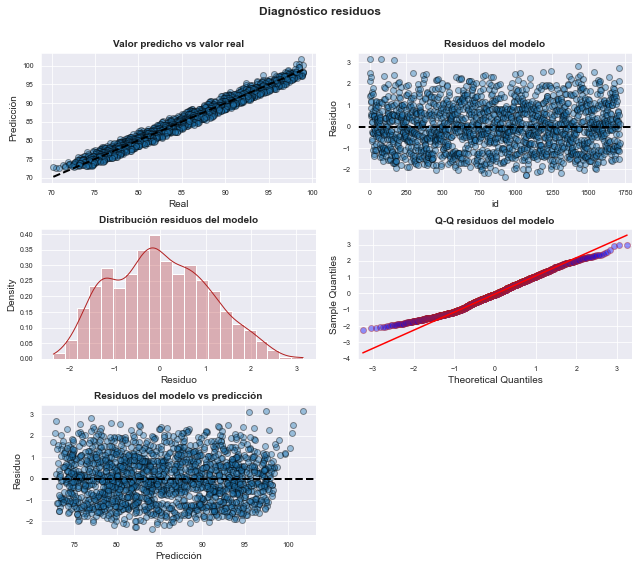

In [90]:
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
#X_train = sm.add_constant(X_train, prepend=True)
import statsmodels.api as sm

X = newvcs1[['E_rc', 'EE', 'ET', 'EV']]
#X = newvcs1[['E_rc', 'EE', 'ET']]
y = newvcs1['P']

modelo = sm.OLS(endog=y, exog=X,)
modelo = modelo.fit()
print(modelo.summary())


print('\n==============================================================================')
print('Intervalos de confianza para los coeficientes del modelo')
intervalos_ci = modelo.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
print(intervalos_ci)


print('\n==============================================================================')
print('Diagnóstico errores (residuos) de las predicciones de entrenamiento')

prediccion_train = modelo.predict(exog = X)
residuos_train   = prediccion_train - y

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

y_train = y
axes[0, 0].scatter(y, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [91]:
modelo.rsquared

0.9998476234509125

In [92]:
print('Los coeficientes del ajuste multiple:\n', modelo.params)

Pcontract = (E_rc*modelo.params[0] + E_rc*E_rc*modelo.params[1] + E_rc*T_rc*modelo.params[2] + E_rc*V_rc*modelo.params[3])*(1-0.05)
#Pcontract = (E_rc*modelo.params[0] + E_rc*E_rc*modelo.params[1] + E_rc*T_rc*modelo.params[2])*(1-0.05)
print('\nThe actual capacity rating:', Pcontract, 'MW')


Los coeficientes del ajuste multiple:
 E_rc    0.111147
EE     -0.000008
ET     -0.000230
EV     -0.000043
dtype: float64

The actual capacity rating: 84.84878205845548 MW


# ·····························································

# Aceptance Criteria 

# ·····························································

The actual capacity rating must be equal to or greater than the contract capacity rating 

Pactual >= Pcontract

In [93]:
print('Pactual:', Pactual, 'MW')
print('Pcontract:', Pcontract, 'MW')

if Pactual > Pcontract:
    print('\n', round(Pactual, 4), 'MW ', '>', round(Pcontract,4), 'MW')
else:
    print('\n', round(Pactual, 4), 'MW ', '<', round(Pcontract,4), 'MW')

Pactual: 88.18748188157363 MW
Pcontract: 84.84878205845548 MW

 88.1875 MW  > 84.8488 MW


In [94]:
Pcontract1 = (E_rc*modelo.params[0] + E_rc*E_rc*modelo.params[1] + E_rc*T_rc*modelo.params[2] + E_rc*V_rc*modelo.params[3] )
Pcontract1

89.31450742995314

In [95]:
(E_rc*modelo.params[0] + E_rc*E_rc*modelo.params[1] + E_rc*T_rc*modelo.params[2] + E_rc*V_rc*modelo.params[3])

#(E_rc*modelo.params[0] + E_rc*E_rc*modelo.params[1] + E_rc*T_rc*modelo.params[2])*(1/10**6)

89.31450742995314

In [96]:
((Pactual/((E_rc*modelo.params[0] + E_rc*E_rc*modelo.params[1] + E_rc*T_rc*modelo.params[2] + E_rc*V_rc*modelo.params[3] )))-1)*100

#((Pactual/((E_rc*modelo.params[0] + E_rc*E_rc*modelo.params[1] + E_rc*T_rc*modelo.params[2] )*(1/10**6)))-1)*100

-1.2618616849713882

In [97]:
((Pactual-Pcontract1)/Pcontract1)*100

-1.2618616849713933

In [98]:
(Pactual-Pcontract1)

-1.1270255483795069

In [99]:
(((Pactual-(Pcontract)))/(Pcontract))*100

3.934882436872215

In [100]:
(Pactual-(Pcontract))

3.338699823118148

## Summary

# Capacity test

   ### Reporting conditions
   
$E_{RC}$ = 929.66 $W/m^2$ 

$T_{RC}$ = 30.79 $ºC$
      
$V_{RC}$ = 3.26 $m/s$ 

   ### Actual Capacity Rating
   
   ### $P_{actual} = 88.187 MW $  
    
    · Días 15, (16), 17, 18, 19, (20)
    · 64 registros
    · Coeficientes ajuste múltiple: 
   {$a_1$, $a_2$, $a_3$, $a_4$} = {0.084705, -0.0000007, 0.000232, 0.000716}
   
   ### Contract Capacity Rating
    
   ### $P_{contract} = 89.683 MW $
   
     · Agosto
     · 191 registros
     · Coeficientes ajuste múltiple: 
{$a_1$, $a_2$, $a_3$, $a_4$} = { 0.112067, -0.000006, -0.000336, 0.000027}

   #### Performance Test Tolerance = 5%
    
   ### $P_{contract} *$ $(1-Performance Test Tolerance) = 85.198 MW $
   
   ## $({P_{actual}} - {P_{contract}}) = -1.553 MW$
   
   ## $({P_{actual}} - {P_{contract}}) / {P_{contract}} = -1.78 \% $
   
   ## $({P_{actual}} - {P_{contract}*0.95}) = 3.338 MW$
   
   ## $({P_{actual}} - {P_{contract}*0.95}) / {P_{contract}*0.95} = 3.934 \% $

# 